## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline
# set the seed
random.seed(42)

`1.`read in the `ab_data.csv` data. Store it in `df`

Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [6]:
df.drop_duplicates().converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('(landing_page == "new_page" and group == "control") or (landing_page == "old_page" and group == "treatment")').count()[0]

3893

Check missing values?

In [8]:
df.dropna().count()[0]

294478

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [9]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [10]:
# Double Check all of the correct rows were removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Unique **user_id**s in **df2**

In [11]:
df2['user_id'].nunique()

290584

Find **user_id** repeated in **df2**

In [12]:
df2[df2.duplicated('user_id')] ['user_id']

2893    773192
Name: user_id, dtype: int64

Row information for the repeat **user_id** 

In [13]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**.

In [14]:
df2.drop(2893, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`4.` 

Probability of an individual converting regardless of the page they receive.

In [15]:
conversion_rate_avg = df2.converted.mean()
conversion_rate_avg

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted.

In [16]:
conversion_rate_control = df2.query('group == "control"').converted.mean()
conversion_rate_control

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted.

In [17]:
conversion_rate_treatment = df2.query('group == "treatment"').converted.mean()
conversion_rate_treatment

0.11880806551510564

Probability that an individual received the new page.

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

**Conclusion: There is not sufficient evidence to show new treatment leads to morec onversions because conversion rate is lower for treatment group.**

<a id='ab_test'></a>
### Part II - A/B Test

Hypothesis testing in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}: p_{new} \leq p_{old}$ 

$H_{1}: p_{new} > p_{old}$  


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


**conversion rate** for $p_{new}$ and $p_{old}$ under the null

In [19]:
conversion_rate_avg

0.11959708724499628

Check $n_{new}$, the number of individuals in the treatment group.

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

Check $n_{old}$, the number of individuals in the control group.

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.

In [22]:
new_page_converted = np.random.choice([0,1],size = n_new, p=[1-conversion_rate_avg, conversion_rate_avg])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.

In [23]:
old_page_converted = np.random.choice([0,1],size = n_old, p=[1-conversion_rate_avg, conversion_rate_avg])

Find $p_{new}$ - $p_{old}$ for simulated values.

In [24]:
new_page_converted.mean() - old_page_converted.mean()

0.00085131956945419529

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1],size = n_new, p=[1-conversion_rate_avg, conversion_rate_avg])
    old_page_converted = np.random.choice([0,1],size = n_old, p=[1-conversion_rate_avg, conversion_rate_avg])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Plot a histogram of the **p_diffs**. 

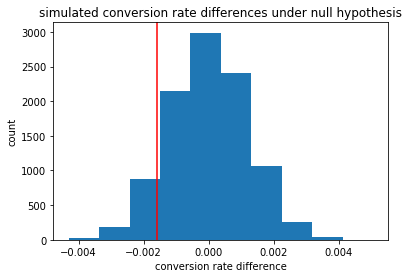

In [26]:
plt.hist(p_diffs)
plt.title('simulated conversion rate differences under null hypothesis')
plt.ylabel('count')
plt.xlabel('conversion rate difference')
plt.axvline(conversion_rate_treatment - conversion_rate_control, color = 'red')

Proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**.

In [27]:
(p_diffs > (conversion_rate_treatment - conversion_rate_control)).mean()

0.90239999999999998

**Conclusion: p-value is 0.91, which is much greater than the criteria 0.05 or 0.01. So we can't reject the null hypothesis.**

Use a built-in to achieve similar results instead.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').user_id.count()
convert_new = df2.query('group == "treatment" & converted == 1').user_id.count()


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Use `stats.proportions_ztest` to compute test statistic and p-value.  

In [29]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = "larger")

(-1.3109241984234394, 0.90505831275902449)

**Conclusion: We interpret the result that the conversion difference in experiment is less than 1.3 standard deviation from the simulation mean average and we can't reject the null hypothesis because p-value > 0.05. They agree with the previous findings.**

<a id='regression'></a>
### Part III - A regression approach


**Perform Logitstic regression to see if there is a significant difference in conversion based on which page a customer receives.**

In [30]:
# create an intercept
df2['intercept'] = 1
df2[['ab_page','old_page']] = pd.get_dummies(df2['landing_page'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


Instantiate the regression model and fit the model to predict whether or not an individual converts.

In [32]:
statmodels = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = statmodels.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model.

In [33]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-15 20:30 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

The p-value associated with **ab_page** is 0.1899. It is different from 0.91 because it's a two sided t-test. We still don't reject the null hypothesis that treatment doesn't affect conversion rate.

**I am considering other things that might influence whether or not an individual converts. There might be omitted variable bias if we omit confounding variables like age, region and sex. But adding too many additional terms might cause overfitting problems.**

Add an effect based on which country a user lives in. 

In [34]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [35]:
df_join = df2.join(df_country.set_index('user_id'), on = 'user_id')
df_join.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [36]:
df_join[['US','UK','CA']] = pd.get_dummies(df_join['country'])

Look at an interaction between page and country to see if there significant effects on conversion. 

In [37]:
df_join['US_ab_page'] = df_join['US'] * df_join['ab_page']
df_join['CA_ab_page'] = df_join['CA'] * df_join['ab_page']

In [38]:
Logitmodel = sm.Logit(df_join['converted'],df_join[['intercept','ab_page','US','CA','US_ab_page','CA_ab_page']])
results2 = Logitmodel.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [39]:
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-15 20:30 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
US_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
CA_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

**The p-values for ab_page is greater than criterion 0.05. We can't reject the null hypothesis that the new page doesn't affect conversion rate.**

**Decision: Recommend the company to stick to the old page.**

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0